In [8]:
%reload_ext autoreload
%autoreload 3
%matplotlib inline

import tkinter as tk
import re
import os
import numpy
import matplotlib.pyplot as plt
import mne
import stumpy
from tkinter import filedialog
from scipy.stats import pearsonr
from scipy.signal import correlate, correlation_lags, find_peaks, resample
from open_ephys.analysis import Session
from collections import defaultdict

# Return two paths from the current working directory
current = os.getcwd()
parent_1 = os.path.dirname(current)
parent_2 = os.path.dirname(parent_1)
root_dir = os.path.join(parent_2, 'interface')
# Add the root directory to the system path
os.sys.path.append(root_dir)
# H:\github\nnc-ufmg\micromap\src\micromap\interface\micromap_utils.py
from micromap_utils import MicroMAPReader

In [9]:
def organize_files_by_info_and_name(folder_path):
    # Regex pattern to extract: name, date, time, 'ekg', and info
    pattern = re.compile(r'^([a-zA-Z0-9]+)_(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})_ekg_(.+)$')

    file_dict = defaultdict(lambda: defaultdict(list))

    for folder in os.listdir(folder_path):
        match = pattern.match(folder)
        if match:
            name = match.group(1)
            info = match.group(4)
            file_dict[info][name].append(os.path.join(folder_path, folder))
        else:
            print(f"Skipping unmatched filename: {folder}")

    return dict(file_dict)

In [10]:
root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

data_folder = filedialog.askdirectory(title = "Select the folder containing the data to be analyzed")
root.destroy()

file_structure = organize_files_by_info_and_name(data_folder)

from pprint import pprint
pprint(file_structure)

Skipping unmatched filename: comparison
{'1k_2_100': defaultdict(<class 'list'>,
                         {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\oe_2009-01-01_03-12-38_ekg_1k_2_100'],
                          'pc': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\pc_2025-04-20_17-33-22_ekg_1k_2_100']}),
 '1k_5_1000': defaultdict(<class 'list'>,
                          {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\oe_2009-01-01_02-51-55_ekg_1k_5_1000'],
                           'pc': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\pc_2025-04-20_17-13-03_ekg_1k_5_1000']}),
 '2k_01_2000': defaultdict(<class 'list'>,
                           {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\oe_2009-01-01_02-12-29_ekg_2k_01_2000'],
                            'pc': ['C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\\pc_2025-04-20_16-32-23_ekg_2k_01_2000']}),
 '2k_5_1000': defaultdict(<class 'list'>,
                          {'oe': ['C

In [11]:
class read_openephys():
    def __init__(self, path):
        path = [os.path.join(path, sub) for sub in os.listdir(path) if sub.startswith("Record Node") and os.path.isdir(os.path.join(path, sub))]
        if len(path) != 1:    
            raise ValueError("There are more than one Record Nodes")
        else:
            path = path[0]
        
        session = Session(path)
        recordings = session.recordings[0]
        continuous = recordings.continuous[0]
        
        sample_numbers = continuous.sample_numbers[0:-1]
        first_sample_index = sample_numbers[0]
        sample_numbers = sample_numbers - first_sample_index

        sampling_rate = continuous.metadata["sample_rate"]

        channels = continuous.metadata["channel_names"]
        channel_indexes = [i for i in range(len(channels)) if channels[i][0:2] == "CH"]
        data = continuous.get_samples(start_sample_index = 0, end_sample_index = -1, selected_channels = channel_indexes)

        data_shape = numpy.shape(data)

        if len(data_shape) > 1:
            if data_shape[0] > data_shape[1]:
                data = data.transpose()
                data_shape = numpy.shape(data)
        else:
            data_size = data_shape[0]
            data = numpy.reshape(data, (1, data_size))
        
        self.data = [a - numpy.mean(a) for a in data]
        self.data = numpy.array(self.data)
        self.rate = sampling_rate
        self.samples = len(self.data[0])
        self.channels = len(self.data)
        self.max_value = numpy.max(self.data)
        self.min_value = numpy.min(self.data)

    def notch_filter(self, frequencies):
        frequencies = numpy.array(frequencies)
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.notch_filter(self.data[a], self.rate, frequencies)

    def bandpass_filter(self, low, high):
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.filter_data(self.data[a], self.rate, low, high, method='iir')


In [12]:
class analysis():
    def __init__(self, nnc, open_ephys, experiment_name):
        self.nnc = nnc
        self.open_ephys = open_ephys
        self.nnc_data = nnc.data
        self.openephys_data = open_ephys.data
        self.experiment_name = experiment_name
        self.num_channels = len(self.nnc_data)
        self.min_value = min(numpy.min(nnc.data).all(), open_ephys.min_value.all())
        self.max_value = max(numpy.max(nnc.data).all(), open_ephys.max_value.all())

    def plot_all(self, channels = []):                                                                                                                # Clears the last plot made in the interface
        if len(channels) > 0:
            channels_to_plot = channels
        else:
            channels_to_plot = range(0, self.num_channels)
        
        fig, ax = plt.subplots(1, 2, sharey=True)
        for a in channels_to_plot:                                                                                                          # Loop through all the rows of the matrix                             
            ax[0].plot(self.openephys_data[a]*0.001 + a, color = (75/255, 75/255, 75/255, 1), linewidth = 0.5, label = 'OPEN EPHYS')
            ax[0].plot(self.nnc_data[a]*0.001 + a, color = (160/255, 17/255, 8/255, 1), linewidth = 0.5, label = 'MICROMAP')

            channel_fft_nnc = numpy.fft.fft(self.nnc_data[a])
            channel_fft_openephys = numpy.fft.fft(self.openephys_data[a])
            freq = numpy.fft.fftfreq(len(channel_fft_nnc), 1/self.nnc.sampling_freq)
            
            freq = freq[0:int(len(freq)/2)]
            channel_fft_nnc = channel_fft_nnc[0:int(len(channel_fft_nnc)/2)]
            channel_fft_openephys = channel_fft_openephys[0:int(len(channel_fft_openephys)/2)]
            
            ax[1].plot(freq, numpy.abs(channel_fft_nnc)/numpy.max(numpy.abs(channel_fft_nnc)) + a, color = (160/255, 17/255, 8/255, 1), linewidth = 0.5, label = 'MICROMAP')
            ax[1].plot(freq, numpy.abs(channel_fft_openephys)/numpy.max(numpy.abs(channel_fft_openephys)) + a, color = (75/255, 75/255, 75/255, 1), linewidth = 0.5, label = 'OPEN EPHYS')

        ax[0].set_ylabel('CHANNELS', fontsize=16)
        ax[0].set_xlabel('TIME (s)', fontsize=16)
        ax[0].legend(['OPEN EPHYS', 'MICROMAP'], fontsize=14, loc='upper right')

        ax[1].set_xlabel('FREQUENCY (Hz)', fontsize=16)
        ax[1].set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax[1].legend(['OPEN EPHYS', 'MICROMAP'], fontsize=14, loc='upper right')
        
        plt.suptitle(self.experiment_name + " (in uV)")
        plt.tight_layout()
        plt.show()

    def correlaction(self, channel, samples, figures_folder = None):
        corr = correlate(self.nnc_data[channel][:samples], self.openephys_data[channel][:samples])
        lags = correlation_lags(len(self.nnc_data[channel][:samples]), len(self.openephys_data[channel][:samples]))
        
        corr = corr/(numpy.linalg.norm(self.nnc_data[channel][:samples]) * numpy.linalg.norm(self.openephys_data[channel][:samples]))
        
        if self.nnc.sampling_freq != self.open_ephys.rate:
            raise ValueError('Sample rate are different between both datasets')
        else:
            time_range = numpy.arange(samples)/self.nnc.sampling_freq

        print('Max correlation: ' + str(numpy.max(corr)) + ' at lag: ' + str(lags[numpy.argmax(corr)]/self.nnc.sampling_freq) + ' seconds')

        fig, (ax_nnc, ax_ope, ax_corr) = plt.subplots(3, 1, figsize=(10, 10))
        ax_nnc.plot(time_range, self.nnc_data[channel][:samples], color = (160/255, 17/255, 8/255, 1), linewidth = 2)
        ax_nnc.set_title(self.experiment_name + ' (channel ' + str(channel + 1) + ')\n\n' + 'MICROMAP', fontsize=16)
        ax_nnc.set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax_nnc.set_xlabel('TIME (s)', fontsize=16)
        ax_ope.plot(time_range, self.openephys_data[channel][:samples], color = (75/255, 75/255, 75/255, 1), linewidth = 2)
        ax_ope.set_title('OPEN EPHYS', fontsize=18)
        ax_ope.set_xlabel('TIME (s)', fontsize=16)
        #ax_ope.set_xlabel('Time (seconds)', fontsize=14)
        ax_ope.set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax_corr.plot(lags/self.nnc.sampling_freq, corr)
        ax_corr.set_title('CROSS-CORRELATED SIGNAL', fontsize=18)
        ax_corr.set_xlabel('LAG (s)', fontsize=14)
        ax_nnc.margins(0, 0.1)
        ax_ope.margins(0, 0.1)
        ax_corr.margins(0, 0.1)

        # set tick labels font
        for label in (ax_nnc.get_xticklabels() + ax_nnc.get_yticklabels() + ax_ope.get_xticklabels() + ax_ope.get_yticklabels() + ax_corr.get_xticklabels() + ax_corr.get_yticklabels()):
            label.set_fontsize(16)
        
        plt.tight_layout()
        if figures_folder != None:
            plt.savefig(figures_folder + '/corr_' + self.experiment_name.lower().replace(' ', '_') + '.png')
            plt.savefig(figures_folder + '/corr_' + self.experiment_name.lower().replace(' ', '_') + '.svg')
        else:
            plt.show()

    def lag_correction(self, use_channels = []):
        openephys_len = len(self.openephys_data[0])
        nnc_len = len(self.nnc_data[0])
        window_init = int(0.05*openephys_len)
        window_end = int(0.1*openephys_len)

        if len(use_channels) > 0:
            search_by = self.openephys_data[[use_channels[0], use_channels[1]], window_init:window_end]
            search_in = self.nnc_data[[use_channels[0], use_channels[1]], 0:int(0.2*openephys_len)]
        else:
            search_by = self.openephys_data[:, window_init:window_end]
            search_in = self.nnc_data[:, 0:int(0.2*openephys_len)]

        search_by = search_by.astype(numpy.float64)
        search_in = search_in.astype(numpy.float64)

        match = stumpy.match(search_by, search_in, max_matches = 1, normalize = True)
        match_indices = match[:, 1]

        if len(match_indices) == 0:
            raise ValueError('No match found')
        elif len(match_indices) > 1:
            raise ValueError('More than one match found')
        else:
            lag = int(match_indices[0]) - window_init

        print(f'The lag is {lag} samples')

        if lag > 0:
            self.nnc_data = self.nnc_data[:, lag:]
        else:
            self.openephys_data = self.openephys_data[:, abs(lag):]
        
        openephys_len = len(self.openephys_data[0])
        nnc_len = len(self.nnc_data[0])

        if nnc_len > openephys_len:
            self.nnc_data = self.nnc_data[:, :openephys_len]
        else:
            self.openephys_data = self.openephys_data[:, :nnc_len]

    def psd(self):
        plt.psd(self.nnc_data[0], NFFT=None, Fs=2000, Fc=None, detrend=None, window=None, noverlap=100, pad_to=None, sides=None, scale_by_freq=None, return_line=None)
        plt.title(self.experiment_name)
        plt.show()

    def average_window(self, sampling_frequency, plot = True, figures_folder = None):
        window = int(sampling_frequency/10)
        heart_beat_nnc = []
        for a in range(0, self.num_channels):
            peaks_nnc = find_peaks(self.nnc_data[a], height=180, distance=300)
            for peak in peaks_nnc[0][1:-1]:
                heart_beat_nnc.append(list(self.nnc_data[a][peak-window:peak+window]))

        heart_beat_nnc = numpy.array(heart_beat_nnc)
        self.average_nnc = numpy.mean(heart_beat_nnc, axis=0)

        heart_beat_openephys = []
        for a in range(0, self.num_channels):
            peaks_openephys = find_peaks(self.openephys_data[a], height=180, distance=300)
            for peak in peaks_openephys[0][1:-1]:
                heart_beat_openephys.append(list(self.openephys_data[a][peak-window:peak+window]))

        heart_beat_openephys = numpy.array(heart_beat_openephys)
        self.average_openephys = numpy.mean(heart_beat_openephys, axis=0)

        if plot:
            fig, (ax) = plt.subplots(1, 1, figsize=(4.8, 4.8))
            ax.plot(self.average_nnc, color = (160/255, 17/255, 8/255, 1), linewidth = 2)
            ax.plot(self.average_openephys, color = (75/255, 75/255, 75/255, 1), linewidth = 2)
            ax.set_xlabel('TIME (s)', fontsize=16)
            # ax.set_xlabel('Tempo (segundos)', fontsize=14)
            ax.set_ylabel('AMPLITUDE (uV)', fontsize=16)
            ax.margins(0, 0.1)
            ax.margins(0, 0.1)
            ax.legend(['MICROMAP','OPEN EPHYS'], fontsize=14)
            #plt.title(self.experiment_name)
            print(self.experiment_name + '.png')

            # set tick labels font
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontsize(16)

            plt.tight_layout()
            if figures_folder != None:
                plt.savefig(figures_folder + '/avg_' + self.experiment_name.lower().replace(' ', '_') + '.png')
                plt.savefig(figures_folder + '/avg_' + self.experiment_name.lower().replace(' ', '_') + '.svg')
            else:
                plt.show()

    def person_correlation(self):
        # correlaction = numpy.corrcoef(self.average_nnc, self.average_openephys)
        # return correlaction[0][1]

        # correlation = pearsonr(self.average_nnc, self.average_openephys)
        correlation = []
        p_value = []

        for channel in range(self.num_channels):
            corr = pearsonr(self.nnc_data[channel,:], self.openephys_data[channel,:])
            p_value.append(corr[1])
            correlation.append(corr[0])
        
        return correlation, p_value
    
    def euclidean_distance(self):
        distance = numpy.linalg.norm(self.average_nnc - self.average_openephys)
        return distance
        

In [24]:
%matplotlib qt

signal_correlation = []
signal_correlation_p_value = []

root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

figures_folder = filedialog.askdirectory(title = "Select the folder to save figures")
root.destroy()

validation = {}

for count_n, n in enumerate(file_structure):
    if count_n == 0:
        validation[n] = {}
        oe_folder = file_structure[n]['oe'][0]
        pc_folder = file_structure[n]['pc'][0]
        print('Open Ephys file: ' + oe_folder)
        print('PC file: ' + pc_folder)

        validation[n]['open_ephys'] = read_openephys(oe_folder)
        # validation[n]['open_ephys'].notch_filter([30, 60, 120])
        validation[n]['open_ephys'].bandpass_filter(1, 100)
        validation[n]['num_channels'] = validation[n]['open_ephys'].channels
        validation[n]['sample_frequency'] = validation[n]['open_ephys'].rate

        validation[n]['nnc'] = MicroMAPReader(pc_folder)
        # validation[n]['nnc'].notch_filter([30, 60, 120])
        validation[n]['nnc'].bandpass_filter(1, 100)

        print(f'Data size: (OE) {validation[n]["open_ephys"].samples} - (NNC) {validation[n]["nnc"].data.shape[1]}')

        if validation[n]['nnc'].num_channels != validation[n]['num_channels']:
            raise ValueError('Number of channels are different between both datasets - NNC: ' + str(validation[n]['nnc'].num_channels) + ' - Open Ephys: ' + str(validation[n]['num_channels']))
        if validation[n]['nnc'].sampling_freq != validation[n]['sample_frequency']:
            print('Sample rate are different between both datasets - NNC: ' + str(validation[n]['nnc'].sampling_freq) + ' - Open Ephys: ' + str(validation[n]['sample_frequency']))
            if validation[n]['nnc'].sampling_freq > validation[n]['sample_frequency']:
                validation[n]['nnc'].data = resample(validation[n]['nnc'].data, int(validation[n]['nnc'].sampling_freq/validation[n]['sample_frequency']*validation[n]['nnc'].data.shape[1]), axis=1)
                validation[n]['nnc'].sampling_freq = validation[n]['sample_frequency']
            else:
                validation[n]['nnc'].data = resample(validation[n]['nnc'].data, int(validation[n]['sample_frequency']/validation[n]['nnc'].sampling_freq*validation[n]['nnc'].data.shape[1]), axis=1)
                validation[n]['nnc'].sampling_freq = validation[n]['sample_frequency']
        packet_loss = validation[n]['nnc'].check_packet_counter(plot = False)
        if packet_loss == False:
            raise ValueError('Packet loss detected in the NNC data')

        experiment_name = os.path.basename(pc_folder)

        validation[n]['experiment_name'] = experiment_name
        validation[n]['comparision'] = analysis(validation[n]['nnc'], validation[n]['open_ephys'], validation[n]['experiment_name'])

        if count_n < len(file_structure) - 1:
            random_channels = numpy.random.randint(0, 16, 2)
            validation[n]['comparision'].lag_correction(use_channels = random_channels)
            validation[n]['comparision'].lag_correction(use_channels = random_channels)
            validation[n]['comparision'].plot_all(channels = list(range(0, 2)))
        else:
            random_channels = numpy.random.randint(17, 32, 2)
            validation[n]['comparision'].lag_correction(use_channels = random_channels)
            validation[n]['comparision'].plot_all(channels = list(range(17, 19)))


        # if count_n < len(file_structure) - 1:
        #     validation[n]['comparision'].correlaction(0, int(validation[n]['nnc'].sampling_freq), figures_folder = figures_folder)
        #     # validation[n]['comparision'].correlaction(0, int(validation[n]['nnc'].sampling_freq), figures_folder = None)
        # else:
        #     validation[n]['comparision'].correlaction(17, int(validation[n]['nnc'].sampling_freq), figures_folder = figures_folder)
        #     # validation[n]['comparision'].correlaction(17, int(validation[n]['nnc'].sampling_freq), figures_folder = None)
        # # validation[n]['comparision'].average_window(validation[n]['nnc'].rate, plot = True, figures_folder = figures_folder)
        # # validation[n]['comparision'].average_window(validation[n]['nnc'].rate, plot = True, figures_folder = None)

        # validation[n]['pearson'] = validation[n]['comparision'].person_correlation()
        # signal_correlation.append(validation[n]['pearson'][0])
        # signal_correlation_p_value.append(validation[n]['pearson'][1])

        # print('Experiment ' + str(n) + ': ' + str(signal_correlation[-1]))

Open Ephys file: C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\oe_2009-01-01_02-12-29_ekg_2k_01_2000
PC file: C:/Users/mcjpe/Desktop/micromap_test/micromap_pc\pc_2025-04-20_16-32-23_ekg_2k_01_2000
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00

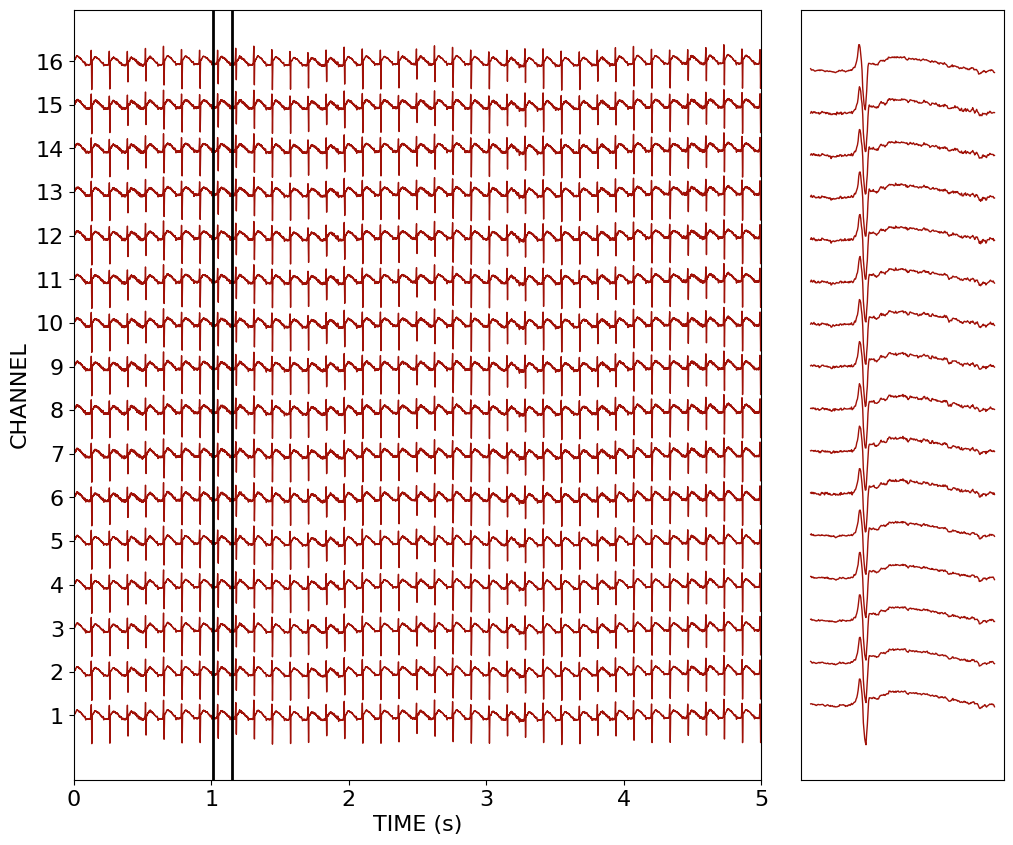

In [ ]:
obj = validation[1]['nnc']
data = obj.data
rate = obj.rate
  
num_channels = data.shape[0]                                                                                       
time = numpy.arange(data.shape[1])                                                                                 # Creates a vector with the number of samples lenght
time = time /rate                                                                                                   # Converts the samples to seconds

fig = plt.figure(figsize=(12, 10))                                                                                 # Creates a figure with the size of 10x5 inches
ax_0 = fig.add_subplot(1, 4, (1,3))                                                                                  # Creates a 1x3 matrix of subplots
ax_1 = fig.add_subplot(1, 4, 4)                                                                                  # Creates a 1x1 matrix of subplots

lim_0 = 2020
lim_1 = 2300

for ch in range(num_channels):                                                                                             # Loop through all the rows of the matrix
    ax_0.plot(time, data[ch]*0.001 + ch + 1, color = (160/255, 17/255, 8/255, 1), linewidth = 1)
    ax_1.plot(time[lim_0:lim_1], data[ch, lim_0:lim_1]*0.002 + ch + 1, color = (160/255, 17/255, 8/255, 1), linewidth = 1)


ax_0.axvline(x = lim_0/rate, color = 'black', linestyle = '-', linewidth = 2)
ax_0.axvline(x = lim_1/rate, color = 'black', linestyle = '-', linewidth = 2)
ax_0.set_xlabel('TIME (s)', fontsize = 16)
ax_0.set_ylabel('CHANNEL', fontsize = 16)
ax_0.set_yticks(range(1, num_channels + 1))
ax_0.set_yticklabels(range(1, num_channels + 1))
ax_0.set_xlim(0, time[10000])

ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_xticks([])
ax_1.set_yticks([])

# set tick labels font
for label in (ax_0.get_xticklabels() + ax_0.get_yticklabels()):
    label.set_fontsize(16)

# plt.savefig(figures_folder + '/raw_' + experiment_name.lower().replace(' ', '_') + '_all.png')
# plt.savefig(figures_folder + '/raw_' + experiment_name.lower().replace(' ', '_') + '_all.svg')

plt.show()

In [14]:
print(signal_correlation)

for experiment in range(len(signal_correlation)):
    print('Experiment ' + str(experiment) + ': ' + str(signal_correlation[experiment]))

# print('Mean correlaction: ' + str(numpy.mean(signal_correlation)))
# print('Standard deviation: ' + str(numpy.std(signal_correlation)))

print(len(signal_correlation))

[[np.float64(0.0960936523433338), np.float64(0.09589710841975764), np.float64(0.09568966983025019), np.float64(0.09497066837078014), np.float64(0.0955491209700837), np.float64(0.09584663680880445), np.float64(0.09570572803757747), np.float64(0.09536324866305229), np.float64(0.09410239937183672), np.float64(0.09529835111473531), np.float64(0.0929279344265646), np.float64(0.09489586521654157), np.float64(0.09388558070806681), np.float64(0.09481540850643992), np.float64(0.09447690525387252), np.float64(0.09514949165451411), np.float64(0.0393806988151892), np.float64(0.033065957659906595), np.float64(0.03968650684550003), np.float64(0.04950986221686435), np.float64(0.03991939138199468), np.float64(0.03460900809411704), np.float64(0.034642773980330256), np.float64(0.04015127890836594), np.float64(0.02819248952791912), np.float64(0.04120793885033508), np.float64(0.02923263746237943), np.float64(0.02548451945129504), np.float64(0.024697815286080827), np.float64(0.030709041690759997), np.float

In [ ]:
import numpy as np

def get_unfold_counter(counter_series, max_value = 255):
    counter_series = np.asarray(counter_series)
    unfolded = [counter_series[0]]
    rollover = 0
    
    for i in range(1, len(counter_series)):
        current = counter_series[i]
        prev = counter_series[i-1]

        if current < 0 or current > max_value:
            raise ValueError("Counter value out of bounds")
        
        if current < prev:
            rollover += 1
        
        unfolded.append((current + rollover * (max_value + 1)))
    
    return np.array(unfolded)

In [63]:
get_unfold_counter([255, 1, 2, 3, 4, 255, 0, 1], max_value = 255)

array([255, 257, 258, 259, 260, 511, 511, 512])

In [13]:
packet_counter = int.from_bytes(bytearray([0x01, 0x00]), byteorder='little')
print(packet_counter)

1
